In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(os.environ["CUDA_VISIBLE_DEVICES"],torch.cuda.device_count(), torch.cuda.current_device())

2 1 0


In [2]:
import os
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from tqdm import tqdm
from torch import optim
# from utils import *
# from modules import UNet
import logging
from torch.utils.tensorboard import SummaryWriter

import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
from torch.nn import init
import torch.nn.functional as F
from torch import optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
import math

print(torch.__version__)
torch.cuda.is_available()

import h5py


1.12.0+cu102


In [3]:
class Diffusion:
    def __init__(self, noise_steps=1000, beta_start=1e-4, beta_end=0.02, img_size=[32, 16, 16], device="cuda"):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.img_size = img_size
        self.device = device

        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

    def prepare_noise_schedule(self):
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)

    def noise_images(self, x, t):
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
        Ɛ = torch.randn_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * Ɛ, Ɛ

    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.noise_steps, size=(n,))

    # def sample(self, model, n):
    #     logging.info(f"Sampling {n} new images....")
    #     model.eval()
    #     with torch.no_grad():
    #         x = torch.randn((n, self.img_size[0], self.img_size[1],self.img_size[2])).to(self.device)
    #         for i in tqdm(reversed(range(1, self.noise_steps)), position=0):
    #             t = (torch.ones(n) * i).long().to(self.device)
    #             predicted_noise = model(x, t)
    #             alpha = self.alpha[t][:, None, None, None]
    #             alpha_hat = self.alpha_hat[t][:, None, None, None]
    #             beta = self.beta[t][:, None, None, None]
    #             if i > 1:
    #                 noise = torch.randn_like(x)
    #             else:
    #                 noise = torch.zeros_like(x)
    #             x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
    #     model.train()
    #     # x = (x.clamp(-1, 1) + 1) / 2
    #     # x = x.clamp(min=0)
    #     # x = (x * 255).type(torch.uint8)
    #     return x
    
    def sample(self, model, n, labels, cfg_scale=3):
        logging.info(f"Sampling {n} new images....")
        model.eval()
        with torch.no_grad():
            x = torch.randn((n, self.img_size[0], self.img_size[1],self.img_size[2])).to(self.device)
            for i in tqdm(reversed(range(1, self.noise_steps)), position=0):
                t = (torch.ones(n) * i).long().to(self.device)
                predicted_noise = model(x, t, labels)
                if cfg_scale > 0:
                    uncond_predicted_noise = model(x, t, None)
                    predicted_noise = torch.lerp(uncond_predicted_noise, predicted_noise, cfg_scale)
                alpha = self.alpha[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
        model.train()
        # x = (x.clamp(-1, 1) + 1) / 2
        # x = (x * 255).type(torch.uint8)
        # x = x.clamp(0, 1)
        # x = torch.softmax(x,dim=1)
        return x

In [4]:
is_wandb = True
if is_wandb:
    import wandb
    wandb.init(project="diff_protein_gen", entity="jathurshan_0330")
    wandb.run.name = "New_Data_Dist_binned_generation_disto+All Angles(Diffusion)_conditioned_SSE_continued_with_recon_loss"
    wandb.run.save()
    # "Finetuning only classification head Ki67 using SIMCLR Pretrained Model"
    exp_path = f"./model_checkpoints/{wandb.run.name}"
    if not os.path.exists(exp_path):
        os.mkdir(exp_path)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jathurshan_0330. Use `wandb login --relogin` to force relogin
/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help` for usage information.


/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help` for usage information.




wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


## Data Loading

In [5]:
file_list = glob.glob("/ssd/Protein_extracted_data/*.h5")
file_list.sort()
print(len(file_list))


new_list = []
for i in file_list:
    with h5py.File(i, "r") as f:
            # dist_ref = np.array(f.get('dist_ref'))
            sse = np.array(f.get('sse'))
            # seq = np.array(f.get('seq'))
            # mask = np.array(f.get('mask'))
            f.close()
    if len(sse.shape)!=0:
        if sse.shape[-1]!=0:
            new_list.append(i)
print(len(new_list))#,error_list)


c = 0
max_value = 0
min_value = 100000

for i in new_list:
    with h5py.File(i, "r") as f:
            dist_ref = np.expand_dims(np.array(f.get('dist_ref')),axis=0)
    if dist_ref.max()>max_value:
        max_value = dist_ref.max()
    if dist_ref.min()<min_value:
        min_value = dist_ref.min()
print(min_value,max_value)

9058
6109
0.0 309.6966314479636


In [6]:
#15051
file_list = new_list#glob.glob("/home/jupyter-jathurshan/Protein_extracted_data/*.h5")
# file_list.sort()
# print(len(file_list))

train_file_list = file_list[:int(len(file_list)*0.8)]
val_file_list = file_list[int(len(file_list)*0.8):int(len(file_list)*0.9)]
test_file_list = file_list[int(len(file_list)*0.9):]

print(len(train_file_list),len(val_file_list),len(test_file_list))

4887 611 611


In [7]:
def plot_sub_plots(rows,columns,img_list,title_list,cmap = 'inferno'):
    fig, axs = plt.subplots(rows, columns, figsize = (columns*10,rows*10))
    if rows == 1:
        for i in range(len(img_list)):
            im1 = axs[i].imshow(img_list[i],cmap=cmap)
            axs[i].set_title(f"{title_list[i]}")
            plt.colorbar(im1, ax=axs[i])#,shrink = 0.3
    else:
        for i in range(len(img_list)):
            im1 = axs[i//columns][i%columns].imshow(img_list[i],cmap=cmap)
            axs[i//columns][i%columns].set_title(f"{title_list[i]}")
            plt.colorbar(im1, ax=axs[i//columns][i%columns])#,shrink = 0.3)
    # plt.show()
    return fig


## Dist ref

In [8]:
import h5py
### Using Distant Ref
class Protein_Dataset(Dataset):
    def __init__(self,file_list, device,pro_len = 64):
      
        self.file_list = file_list
        self.pro_len = pro_len
        self.device = device
        
        self.device = device
        
        print(f"Data_size : {len(self.file_list)}") 
        
    def __len__(self):
        return len(self.file_list )

    def __getitem__(self, idx):
        
        with h5py.File(self.file_list[idx], "r") as f:
            dist_ref = np.array(f.get('dist_ref'))
            dist_ref[np.isnan(dist_ref)] = 0
            sse = np.array(f.get('sse'))
            # seq = np.array(f.get('seq'))
            mask = np.array(f.get('mask'))
            f.close()
        
       
        
        dist_ref = torch.from_numpy(dist_ref).unsqueeze(0).clamp(max=50)
        dist_ref =dist_ref/50
        sse = torch.from_numpy(sse).unsqueeze(0).float()
        # seq = np.array(f.get('seq'))
        mask = torch.from_numpy(mask).squeeze().unsqueeze(0)
        ref_len = dist_ref.shape[-1]
        # print(self.file_list[idx],dist_ref.shape,sse.shape)
        
        # print(self.file_list[idx],dist_ref.shape,mask.shape,sse.shape)
        
#         if dist_ref.shape[-1]<self.pro_len:
#             pad = ((self.pro_len-dist_ref.shape[-1])//2,(self.pro_len-dist_ref.shape[-1])//2,(self.pro_len-dist_ref.shape[-1])//2,(self.pro_len-dist_ref.shape[-1])//2)
#             dist_ref =  F.pad(dist_ref, pad, mode='reflect')
#             mask =  F.pad(mask, pad, mode='constant')
            
#             pad = ((self.pro_len-sse.shape[-1])//2,(self.pro_len-sse.shape[-1])//2)
#             sse =  F.pad(sse, pad, mode='reflect')
#         elif dist_ref.shape[-1]>self.pro_len:
#             crop = transforms.CenterCrop(self.pro_len)
#             dist_ref = crop(dist_ref)
#             mask = crop(mask)
#             crop = transforms.CenterCrop((3,self.pro_len))
#             sse = crop(sse)
         
        if dist_ref.shape[-1]!=self.pro_len:
            crop = transforms.CenterCrop(self.pro_len)
            dist_ref = crop(dist_ref)
            mask = crop(mask)
            crop = transforms.CenterCrop((3,self.pro_len))
            sse = crop(sse)
           
        
#         
        return dist_ref.to(self.device).float(), mask.to(self.device).float(), sse.to(self.device).float(),ref_len

## Disto binned

In [9]:
import h5py
### Using Distant binned
def mtx2bins(x_ref, start, end, nbins, mask):
    bins = np.linspace(start, end, nbins)
    x_true = np.digitize(x_ref, bins).astype(np.uint8)
    x_true[mask] = 0
    return np.eye(nbins+1)[x_true][...,:-1]
class Protein_Dataset(Dataset):
    def __init__(self,file_list, device,pro_len = 64):
      
        self.file_list = file_list
        self.pro_len = pro_len
        self.device = device
        
        self.device = device
        
        print(f"Data_size : {len(self.file_list)}") 
        
    def __len__(self):
        return len(self.file_list )

    def __getitem__(self, idx):
        
        with h5py.File(self.file_list[idx], "r") as f:
            # print(f.keys())
            dist_ref = np.array(f.get('dist_ref'))
            dist_ref[np.isnan(dist_ref)] = 0
            
            omega_ref = np.array(f.get('omega_ref'))
            # omega_ref[np.isnan(omega_ref)] = 0
            
            phi_ref = np.array(f.get('phi_ref'))
            # phi_ref[np.isnan(phi_ref)] = 0
            
            theta_ref = np.array(f.get('theta_ref'))
            # theta_ref[np.isnan(theta_ref)] = 0
            
            sse = np.array(f.get('sse'))
            # seq = np.array(f.get('seq'))
            mask = np.array(f.get('mask'))
            f.close()
        
       
        
        # dist_ref = torch.from_numpy(dist_ref).unsqueeze(0)#.clamp(max=50)
        # dist_ref =dist_ref/50
        dist_ref  = mtx2bins(dist_ref,2.0,  20.0, 37, mask=(dist_ref > 20))#),-1,0)
        omega_ref  = torch.moveaxis(torch.from_numpy(mtx2bins(omega_ref, -np.pi, np.pi, 25, mask=(dist_ref[...,0]==1))),-1,0)
        theta_ref  = torch.moveaxis(torch.from_numpy(mtx2bins(theta_ref, -np.pi, np.pi, 25, mask=(dist_ref[...,0]==1))),-1,0)
        phi_ref  = torch.moveaxis(torch.from_numpy(mtx2bins(phi_ref,0.0, np.pi, 13, mask=(dist_ref[...,0]==1))),-1,0)
        
        dist_ref = torch.moveaxis(torch.from_numpy(dist_ref),-1,0)
        
        # print(dist_ref.shape)
        sse = torch.from_numpy(sse).unsqueeze(0).float()
        # seq = np.array(f.get('seq'))
        mask = torch.from_numpy(mask).squeeze().unsqueeze(0)
        ref_len = dist_ref.shape[-1]
    
         
        if dist_ref.shape[-1]!=self.pro_len:
            crop = transforms.CenterCrop(self.pro_len)
            dist_ref = crop(dist_ref)
            omega_ref = crop(omega_ref)
            theta_ref = crop(theta_ref)
            phi_ref = crop(phi_ref)
            mask = crop(mask)
            crop = transforms.CenterCrop((3,self.pro_len))
            sse = crop(sse)
           
        
#         
        return [dist_ref.to(self.device).float(),omega_ref.to(self.device).float(),theta_ref.to(self.device).float(),phi_ref.to(self.device).float()], mask.to(self.device).float(), sse.to(self.device).float(),ref_len

In [10]:
train_dataset = Protein_Dataset(train_file_list, device = device) 
val_dataset = Protein_Dataset(val_file_list, device = device)

Data_size : 4887
Data_size : 611


In [11]:
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

torch.Size([32, 37, 64, 64]) torch.Size([32, 25, 64, 64]) torch.Size([32, 25, 64, 64]) torch.Size([32, 13, 64, 64]) torch.Size([32, 1, 64, 64]) torch.Size([32, 1, 3, 64]) tensor([327, 418, 120,  90, 343, 564, 615, 105,  44, 446, 277, 131, 244, 349,
        253,  86, 199, 246, 266, 121, 124, 219, 154, 203,  81, 214,  83, 118,
        405, 334,  68, 124])



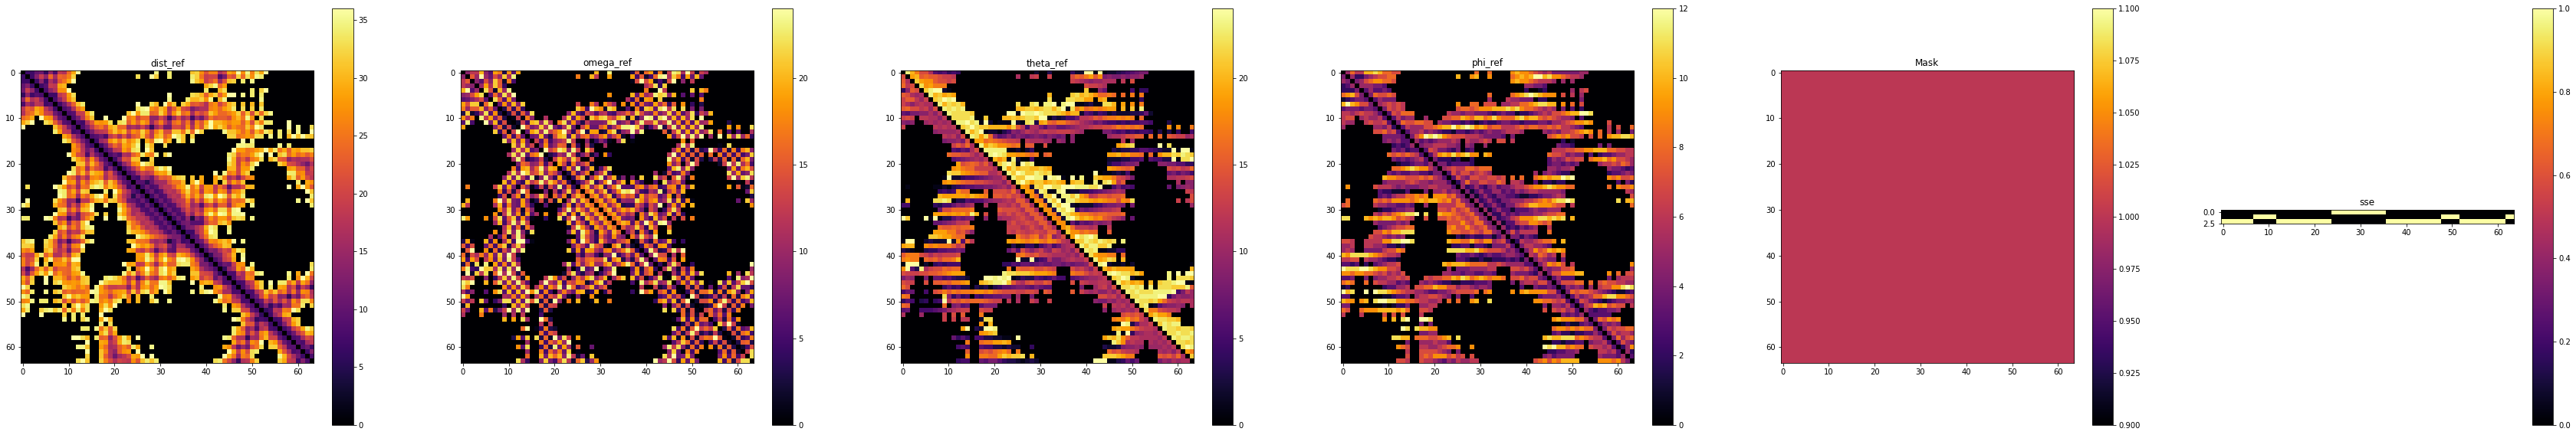

In [12]:
[dist_ref,omega_ref,theta_ref,phi_ref],mask,sse,ref_len   = next(iter(train_data_loader))

print(dist_ref.shape,omega_ref.shape,theta_ref.shape,phi_ref.shape,mask.shape,sse.shape,ref_len) 
ind = 0
img_list = [dist_ref[ind].argmax(0).squeeze().detach().cpu().numpy(),
            omega_ref[ind].argmax(0).squeeze().detach().cpu().numpy(),
            theta_ref[ind].argmax(0).squeeze().detach().cpu().numpy(),
            phi_ref[ind].argmax(0).squeeze().detach().cpu().numpy(),
           mask[ind].squeeze().detach().cpu().numpy(),
           sse[ind].squeeze().detach().cpu().numpy(),
           ]

title_list = ['dist_ref','omega_ref','theta_ref','phi_ref','Mask','sse']
plot_sub_plots(1,6,img_list,title_list,cmap = 'inferno')
print('')

## Autoencoder Model

In [13]:
class CNN_Encoder(nn.Module):
    
    def __init__(self, input_nc=1, ngf = 16):
        super(CNN_Encoder, self).__init__()
        self.enc1 = self.enc_block(in_ch = input_nc, out_ch = ngf, kernel_size=4, stride=2, padding = 1,bias = True, innermost = False  )
        self.enc2 = self.enc_block(in_ch = ngf, out_ch = ngf*2, kernel_size=4, stride=2, padding = 1,bias = True, innermost = False  )
        # self.enc3 = self.enc_block(in_ch = ngf*2, out_ch = ngf*4, kernel_size=4, stride=2, padding = 1,bias = True, innermost = False  )
        # self.enc4 = self.enc_block(in_ch = ngf*4, out_ch = ngf*8, kernel_size=4, stride=2, padding = 1,bias = True, innermost = False  )
        # self.enc5 = self.enc_block(in_ch = ngf*8, out_ch = ngf*16, kernel_size=4, stride=2, padding = 1,bias = True, innermost = False  )
        
        
    def enc_block(self, in_ch, out_ch, kernel_size=4, stride=2, padding = 1,bias = True, innermost = False):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=kernel_size,stride=stride, padding=padding, bias=bias),
                # nn.ReLU()
                )
      
            
    def forward(self, x):
        x = self.enc1(x)
        x = self.enc2(x)
        # x = self.enc3(x)
        # x = self.enc4(x)
        # x = self.enc5(x)
        return x
    

class CNN_Decoder(nn.Module):
    
    def __init__(self, lat_chan=128,out_ch = 1, ngf = 16 ):
        super(CNN_Decoder, self).__init__()
        self.dec1 = self.conv_up_block(in_ch = lat_chan , out_ch = ngf*8, 
                                       kernel_size=4, stride=2, padding = 1,bias = True)
        self.dec2 = self.conv_up_block(in_ch = ngf*8 , out_ch = out_ch, 
                                       kernel_size=4, stride=2, padding = 1,bias = True)
        # self.dec3 = self.conv_up_block(in_ch = ngf*4 , out_ch = ngf*2, 
        #                                kernel_size=4, stride=2, padding = 1,bias = True)
        # self.dec4 = self.conv_up_block(in_ch = ngf*2 , out_ch = 1, 
        #                                kernel_size=4, stride=2, padding = 1,bias = True)
        # self.dec5 = self.conv_up_block(in_ch = ngf , out_ch = 1, 
                                       # kernel_size=4, stride=2, padding = 1,bias = True)
        # self.final = nn.Linear(16,out_ch)
        
        
    def conv_up_block(self,  in_ch, out_ch, kernel_size=4, stride=2, padding = 1,bias = True,outermost = False):
            return nn.Sequential(
                nn.ConvTranspose2d( in_ch, out_ch, kernel_size=kernel_size, stride=stride, padding = padding,bias = bias),
                # nn.ReLU()
                )
        
    def forward(self,x): 
        x = self.dec1(x)
        
        x = self.dec2(x)
        
        
#         x = self.dec3(x)
        
#         x = self.dec4(x)
        # x = self.dec5(x)
        # x = self.final(x)
        # x = torch.moveaxis(x,-1,1)
        return x

In [14]:
class Multi_CNN_Encoder(nn.Module):
    
    def __init__(self, input_nc=1, ngf = 16):
        super(Multi_CNN_Encoder, self).__init__()
        self.dist_enc = CNN_Encoder(input_nc = 37,ngf = 16)#.to(device)
        self.omega_enc = CNN_Encoder(input_nc = 25,ngf = 16)#.to(device)
        self.theta_enc = CNN_Encoder(input_nc = 25,ngf = 16)#.to(device)
        self.phi_enc = CNN_Encoder(input_nc = 13,ngf = 16)#.to(device)
        
    def forward(self,x):
        dist_1 = self.dist_enc(x[0])
        omega_1 = self.omega_enc(x[1])
        theta_1 = self.theta_enc(x[2])
        phi_1 = self.phi_enc(x[3])
        
        lat_c = dist_1+omega_1+theta_1+phi_1
        return lat_c
    
    
class Multi_CNN_Decoder(nn.Module):
    
    def __init__(self, lat_chan=32):
        super(Multi_CNN_Decoder, self).__init__()
        self.dist_dec = CNN_Decoder(lat_chan=32,out_ch=37)#.to(device)
        self.omega_dec = CNN_Decoder(lat_chan=32,out_ch=25)
        self.theta_dec = CNN_Decoder(lat_chan=32,out_ch=25)
        self.phi_dec =CNN_Decoder(lat_chan=32,out_ch=13)
        
    def forward(self,x):
        dist_1 = self.dist_dec(x)
        omega_1 = self.omega_dec(x)
        theta_1 = self.theta_dec(x)
        phi_1 = self.phi_dec(x)
        

        return [dist_1,omega_1,theta_1,phi_1]

In [15]:
####Autoencoder Training Using Binned Distograms Masked loss
enc_path = f'./model_checkpoints/Autoencoder Training Using All Binned Distograms+Angles (Only ones without Masks)/encoder_dist.pth.tar'

### Disto ref autoencoder
# enc_path = f'./model_checkpoints/Autoencoder Training Using Distoref/encoder_dist.pth.tar'
encoder = torch.load(enc_path).to(device)#CNN_Encoder(ngf = 16).to(device)#torch.load(enc_path).to(device)
encoder.eval()
print(sum([np.prod(p.size()) for p in encoder.parameters()]))

####Autoencoder Training Using Binned Distograms Masked loss
dec_path = f'./model_checkpoints/Autoencoder Training Using All Binned Distograms+Angles (Only ones without Masks)/decoder_dist.pth.tar'
### Disto ref autoencoder
# dec_path = f'./model_checkpoints/Autoencoder Training Using Distoref/decoder_dist.pth.tar'
decoder = torch.load(dec_path).to(device)#CNN_Decoder(lat_chan=32).to(device)#torch.load(dec_path).to(device)
decoder.eval()
print(sum([np.prod(p.size()) for p in decoder.parameters()]))

58560
467556


## Encoder SSE

In [16]:
class CNN_1D_Encoder(nn.Module):
    
    def __init__(self, input_nc=3, ngf = 16):
        super(CNN_1D_Encoder, self).__init__()
        self.enc1 = self.enc_block(in_ch = input_nc, out_ch = ngf, kernel_size=4, stride=2, padding = 1,bias = True, innermost = False  )
        self.enc2 = self.enc_block(in_ch = ngf, out_ch = ngf*2, kernel_size=4, stride=2, padding = 1,bias = True, innermost = False  )
        self.enc3 = self.enc_block(in_ch = ngf*2, out_ch = ngf*4, kernel_size=4, stride=2, padding = 1,bias = True, innermost = False  )
        self.enc4 = self.enc_block(in_ch = ngf*4, out_ch = ngf*8, kernel_size=4, stride=2, padding = 1,bias = True, innermost = False  )
        self.enc5 = self.enc_block(in_ch = ngf*8, out_ch = ngf*16, kernel_size=4, stride=2, padding = 1,bias = True, innermost = False  )
        self.enc6 = self.enc_block(in_ch = ngf*16, out_ch = ngf*32, kernel_size=4, stride=2, padding = 1,bias = True, innermost = False  )

        
    def enc_block(self, in_ch, out_ch, kernel_size=4, stride=2, padding = 1,bias = True, innermost = False):
            return nn.Sequential(
                nn.Conv1d(in_ch, out_ch, kernel_size=kernel_size,stride=stride, padding=padding, bias=bias),
                # nn.ReLU()
                )
      
            
    def forward(self, x):
        x = self.enc1(x)
        x = self.enc2(x)
        x = self.enc3(x)
        x = self.enc4(x)
        x = self.enc5(x)
        x = self.enc6(x)
        return x
    



In [17]:
enc_sse_path = f'./model_checkpoints/Autoencoder Training Using SSE/encoder_sse.pth.tar'
encoder_sse = torch.load(enc_sse_path).to(device)#CNN_Encoder(ngf = 16).to(device)#torch.load(enc_path).to(device)
encoder_sse.eval()
print(sum([np.prod(p.size()) for p in encoder.parameters()]))

58560


## UNet

In [18]:
class EMA:
    def __init__(self, beta):
        super().__init__()
        self.beta = beta
        self.step = 0

    def update_model_average(self, ma_model, current_model):
        for current_params, ma_params in zip(current_model.parameters(), ma_model.parameters()):
            old_weight, up_weight = ma_params.data, current_params.data
            ma_params.data = self.update_average(old_weight, up_weight)

    def update_average(self, old, new):
        if old is None:
            return new
        return old * self.beta + (1 - self.beta) * new

    def step_ema(self, ema_model, model, step_start_ema=2000):
        if self.step < step_start_ema:
            self.reset_parameters(ema_model, model)
            self.step += 1
            return
        self.update_model_average(ema_model, model)
        self.step += 1

    def reset_parameters(self, ema_model, model):
        ema_model.load_state_dict(model.state_dict())


class SelfAttention(nn.Module):
    def __init__(self, channels, size):
        super(SelfAttention, self).__init__()
        self.channels = channels
        self.size = size
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x):
        x = x.view(-1, self.channels, self.size * self.size).swapaxes(1, 2)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.swapaxes(2, 1).view(-1, self.channels, self.size, self.size)


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, t):
        x = self.maxpool_conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = nn.Sequential(
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels, in_channels // 2),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, skip_x, t):
        x = self.up(x)
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb


class UNet(nn.Module):
    def __init__(self, c_in=3, c_out=3, time_dim=256, device="cuda"):
        super().__init__()
        self.device = device
        self.time_dim = time_dim
        self.inc = DoubleConv(c_in, 64)
        self.down1 = Down(64, 128)
        self.sa1 = SelfAttention(128, 8)
        self.down2 = Down(128, 256)
        self.sa2 = SelfAttention(256, 4)
        self.down3 = Down(256, 256)
        self.sa3 = SelfAttention(256, 2)

        self.bot1 = DoubleConv(256, 512)
        self.bot2 = DoubleConv(512, 512)
        self.bot3 = DoubleConv(512, 256)

        self.up1 = Up(512, 128)
        self.sa4 = SelfAttention(128, 4)
        self.up2 = Up(256, 64)
        self.sa5 = SelfAttention(64, 8)
        self.up3 = Up(128, 64)
        self.sa6 = SelfAttention(64, 16)
        self.outc = nn.Conv2d(64, c_out, kernel_size=1)

    def pos_encoding(self, t, channels):
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2, device=self.device).float() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc

    def forward(self, x, t):
        t = t.unsqueeze(-1).type(torch.float)
        t = self.pos_encoding(t, self.time_dim)

        x1 = self.inc(x)
        x2 = self.down1(x1, t)
        # print(f"x2: {x2.shape}")
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        # print(f"x3: {x3.shape}")
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        # print(f"x4: {x4.shape}")
        x4 = self.sa3(x4)
        
        # print(f"x4: {x4.shape}")
        x4 = self.bot1(x4)
        x4 = self.bot2(x4)
        x4 = self.bot3(x4)
        
        # print(f"x4: {x4.shape}")
        x = self.up1(x4, x3, t)
        # print(f"x: {x.shape}")
        x = self.sa4(x)
        # print(f"x: {x.shape}")
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        output = self.outc(x)
        return output
    
    
class UNet_Conditional(nn.Module):
    def __init__(self, c_in=3, c_out=3, time_dim=256, device="cuda"):#,num_classes = None):
        super().__init__()
        self.device = device
        self.time_dim = time_dim
        self.inc = DoubleConv(c_in, 64)
        self.down1 = Down(64, 128)
        self.sa1 = SelfAttention(128, 8)
        self.down2 = Down(128, 256)
        self.sa2 = SelfAttention(256, 4)
        self.down3 = Down(256, 256)
        self.sa3 = SelfAttention(256, 2)

        self.bot1 = DoubleConv(256, 512)
        self.bot2 = DoubleConv(512, 512)
        self.bot3 = DoubleConv(512, 256)

        self.up1 = Up(512, 128)
        self.sa4 = SelfAttention(128, 4)
        self.up2 = Up(256, 64)
        self.sa5 = SelfAttention(64, 8)
        self.up3 = Up(128, 64)
        self.sa6 = SelfAttention(64, 16)
        self.outc = nn.Conv2d(64, c_out, kernel_size=1)
        
#         if num_classes is not None:
#             self.label_emb = nn.Embedding(num_classes, time_dim)
        

    def pos_encoding(self, t, channels):
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2, device=self.device).float() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc

    def forward(self, x, t,labels):
        t = t.unsqueeze(-1).type(torch.float)
        t = self.pos_encoding(t, self.time_dim)
        # print(f"t:{t.shape}")
        if labels!=None:
            # print(self.label_emb(labels).shape)
            t = t+ labels
        
        x1 = self.inc(x)
        x2 = self.down1(x1, t)
        # print(f"x2: {x2.shape}")
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        # print(f"x3: {x3.shape}")
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        # print(f"x4: {x4.shape}")
        x4 = self.sa3(x4)
        
        # print(f"x4: {x4.shape}")
        x4 = self.bot1(x4)
        x4 = self.bot2(x4)
        x4 = self.bot3(x4)
        
        # print(f"x4: {x4.shape}")
        x = self.up1(x4, x3, t)
        # print(f"x: {x.shape}")
        x = self.sa4(x)
        # print(f"x: {x.shape}")
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        output = self.outc(x)
        return output

In [19]:
# model = UNet_Conditional(c_in=32, c_out=32, time_dim=256, device="cuda").to(device)
model = torch.load("./model_checkpoints/New_Data_Dist_binned_generation_disto+All Angles(Diffusion)_conditioned_SSE_continued_with_recon_loss/u_net_diff_checkpoint.pth.tar").to(device)
# cond_enc = Cond_Encoder().to(device)
#testing
dist_ref,mask,sse,ref_len   = next(iter(train_data_loader))
# print(digit_labels.shape)

lat_c = encoder(dist_ref)
t = torch.randint(low=1, high=1000, size=(dist_ref[0].shape[0],)).to(device)
labels = encoder_sse(sse.squeeze(1))
print(lat_c.shape,t.shape,labels.shape)

denoised_lat_c = model(lat_c,t,labels.squeeze(-1))

print(denoised_lat_c.shape)

torch.Size([32, 32, 16, 16]) torch.Size([32]) torch.Size([32, 256, 1])
torch.Size([32, 32, 16, 16])


## Training

In [20]:
# optimizer = optim.AdamW(list(model.parameters())+list(cond_enc.parameters()), lr=3e-4)
optimizer = optim.AdamW(model.parameters(), lr=3e-4)
mse = nn.MSELoss()
diffusion = Diffusion(img_size=[32,16,16], device=device)

In [21]:
def recon_loss(x_hat,x):
    criterion = nn.L1Loss()
    return criterion(x_hat,x)

def recon_loss_binned(x_hat,x):
    criterion = nn.CrossEntropyLoss()
    return criterion(x_hat,x)
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count if self.count != 0 else 0
        
def plot_sub_plots(rows,columns,img_list,title_list,cmap = 'inferno'):
    fig, axs = plt.subplots(rows, columns, figsize = (columns*10,rows*10))
    if rows == 1:
        for i in range(len(img_list)):
            im1 = axs[i].imshow(img_list[i],cmap=cmap)
            axs[i].set_title(f"{title_list[i]}")
            plt.colorbar(im1, ax=axs[i])#,shrink = 0.3
    else:
        for i in range(len(img_list)):
            im1 = axs[i//columns][i%columns].imshow(img_list[i],cmap=cmap)
            axs[i//columns][i%columns].set_title(f"{title_list[i]}")
            plt.colorbar(im1, ax=axs[i//columns][i%columns])#,shrink = 0.3)
    # plt.show()
    return fig

In [22]:
def train(model,diffusion,encoder,decoder,encoder_sse,optimizer,data_loader,is_wandb=False,verbose_freq = 500,is_verbose = False):
    encoder.eval()
    decoder.eval()
    encoder_sse.eval()
    model.train()
    # cond_enc.train()
    train_losses = AverageMeter()
    for batch_idx, (x,m,sse,_ ) in enumerate(data_loader):
        x = encoder(x) #x*m
        labels = encoder_sse(sse.squeeze(1))
        
        t = diffusion.sample_timesteps(x.shape[0]).to(device)
        x_t, noise = diffusion.noise_images(x, t)
        predicted_noise = model(x_t, t,labels.squeeze(-1))
        
        loss = mse(noise, predicted_noise) 
        # loss+= recon_loss_binned(x_hat*m,(x.argmax(1).unsqueeze(1)*m).squeeze().type(torch.cuda.LongTensor)) 

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # break
        train_losses.update(loss.data.item())
        if is_wandb:
            wandb.log({"batch_loss": loss.data.item()})
    
    
    if is_wandb:
            wandb.log({"train_epoch_loss": train_losses.avg})
            
    if is_verbose:
        print(f"Training Epoch Loss: {train_losses.avg}")
    
    
    '''
    Inference Script to randomly sample from gaussian and generate structures conditioned
    on SSE
    '''
    x,m,sse,ref_len   = next(iter(data_loader))
    labels = encoder_sse(sse.squeeze(1))
    
    sampled_images = diffusion.sample(model, n=x[0].shape[0],labels = labels.squeeze(-1))
    sampled_images = decoder(sampled_images.float())#.clamp(min=0,max=1)
    # sampled_images = sampled_images.argmax(1).squeeze().detach().cpu().numpy()
    # print(sampled_images.shape)
    sse = sse.squeeze().detach().cpu().numpy()
    # x = x.argmax(1).squeeze().detach().cpu().numpy()
    
    
    img_list = []
    title_list = []
    for i in range(4):
        img_list.append(sampled_images[0][i].argmax(0).squeeze().detach().cpu().numpy())
        img_list.append(sampled_images[1][i].argmax(0).squeeze().detach().cpu().numpy())
        img_list.append(sampled_images[2][i].argmax(0).squeeze().detach().cpu().numpy())
        img_list.append(sampled_images[3][i].argmax(0).squeeze().detach().cpu().numpy())
        img_list.append(sse[i])
        
        img_list.append(x[0][i].argmax(0).squeeze().detach().cpu().numpy())
        img_list.append(x[1][i].argmax(0).squeeze().detach().cpu().numpy())
        img_list.append(x[2][i].argmax(0).squeeze().detach().cpu().numpy())
        img_list.append(x[3][i].argmax(0).squeeze().detach().cpu().numpy())
        img_list.append(sse[i])
        
        title_list+=['dist_ref_Gen','omega_ref_Gen','theta_ref_Gen','phi_ref_Gen','SSE',
                    'dist_ref_GT','omega_ref_GT','theta_ref_GT','phi_ref_GT','SSE']
    
    
#     img_list = [sampled_images[0],sse[0],x[0],sampled_images[1],sse[1],x[1],
#                 sampled_images[2],sse[2],x[2],sampled_images[3],sse[3],x[3],
#                 sampled_images[4],sse[4],x[4],sampled_images[5],sse[5],x[5],
#                 sampled_images[6],sse[6],x[6],sampled_images[7],sse[7],x[7],
#                ] 
    
#     title_list = [ref_len[0].item(),ref_len[0].item(),ref_len[0].item(),ref_len[1].item(),ref_len[1].item(),ref_len[1].item(),
#                   ref_len[2].item(),ref_len[2].item(),ref_len[2].item(),ref_len[3].item(),ref_len[3].item(),ref_len[3].item(),
#                   ref_len[4].item(),ref_len[4].item(),ref_len[4].item(),ref_len[5].item(),ref_len[5].item(),ref_len[5].item(),
#                   ref_len[6].item(),ref_len[6].item(),ref_len[6].item(),ref_len[7].item(),ref_len[7].item(),ref_len[7].item(),]
    
    fig = plot_sub_plots(8,5,img_list,title_list,cmap = 'inferno')
    if is_wandb:
            wandb.log({"examples": wandb.Image(fig)})
    
    return train_losses.avg





    # sampled_images = diffusion.sample(model, n=images.shape[0])
    # save_images(sampled_images, os.path.join("results", args.run_name, f"{epoch}.jpg"))
    # torch.save(model.state_dict(), os.path.join("models", args.run_name, f"ckpt.pt"))


In [ ]:
best_loss = 10000000
train_loss_list = []
n_epochs = 5000

# if not os.path.exists(exp_path):
#     os.mkdir(exp_path)
# print("Training ", end='')
for epoch_idx in range(n_epochs):
    # print('=', end='')
    
    train_loss = train(model,diffusion,encoder,decoder,encoder_sse,optimizer,train_data_loader,is_wandb=is_wandb)     

    train_loss_list.append(train_loss)
    
    
    print(f"Epoch {epoch_idx+1}: {train_loss} ")
    if (train_loss < best_loss): 
        best_loss = train_loss
        # print("Saving Best Model =======================================>")
        torch.save(model, f'{exp_path}/u_net_diff_best_loss.pth.tar')
        # torch.save(cond_enc, f'{exp_path}/cond_enc_diff.pth.tar')
    if (epoch_idx+1)%10 == 0:
        torch.save(model, f'{exp_path}/u_net_diff_checkpoint.pth.tar')
                       
torch.save(model, f'{exp_path}/u_net_diff_final.pth.tar')    
print('Training Completed')

999it [00:16, 58.77it/s]


Epoch 1: 0.35217006455839067 


999it [00:17, 58.48it/s]


Epoch 2: 0.34266392730809503 


999it [00:17, 58.63it/s]


Epoch 3: 0.3507567046124951 


999it [00:17, 58.48it/s]


Epoch 4: 0.340925169146918 


999it [00:17, 58.46it/s]


Epoch 5: 0.3394920844462962 


999it [00:16, 59.11it/s]


Epoch 6: 0.3420988514142878 


999it [00:16, 60.80it/s]


Epoch 7: 0.3420691384988673 


999it [00:16, 58.88it/s]


Epoch 8: 0.34518932575493855 


999it [00:17, 58.52it/s]


Epoch 9: 0.34801683501870023 


999it [00:17, 58.50it/s]


Epoch 10: 0.3489338485828412 


999it [00:17, 58.49it/s]


Epoch 11: 0.34139886498451233 


999it [00:17, 58.08it/s]


Epoch 12: 0.3477587086312911 


999it [00:17, 58.34it/s]


Epoch 13: 0.3550793476938422 


999it [00:17, 58.40it/s]


Epoch 14: 0.3423044998077006 


999it [00:17, 58.14it/s]


Epoch 15: 0.3451914229229385 


999it [00:17, 58.48it/s]


Epoch 16: 0.33782602155130675 


999it [00:17, 58.46it/s]


Epoch 17: 0.34873616734361335 


999it [00:16, 58.89it/s]


Epoch 18: 0.3489365429660074 


999it [00:17, 57.96it/s]


Epoch 19: 0.34933768388103037 


999it [00:17, 58.09it/s]


Epoch 20: 0.3443838121259914 


999it [00:16, 59.74it/s]
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Epoch 21: 0.3437834369396073 


999it [00:16, 59.43it/s]


Epoch 22: 0.3473580771801518 


999it [00:16, 58.89it/s]


Epoch 23: 0.3445996416160484 


999it [00:17, 58.19it/s]


Epoch 24: 0.3470343513036865 


999it [00:17, 58.69it/s]


Epoch 25: 0.3422960753923927 


999it [00:17, 58.46it/s]


Epoch 26: 0.3464612356977525 


999it [00:17, 58.33it/s]


Epoch 27: 0.34805046041416965 


999it [00:24, 40.59it/s]


Epoch 28: 0.3500261850216809 


999it [00:17, 57.95it/s]


Epoch 29: 0.34988804599818063 


999it [00:17, 58.46it/s]


Epoch 30: 0.3471855781241959 


999it [00:17, 58.35it/s]


Epoch 31: 0.34342800460609735 
